In [1]:
from bs4 import BeautifulSoup
from DataProcessing.Utils import *
import mdtraj as md
import os

import os
import numpy as np
import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis import nuclinfo
from MDAnalysis import *
import matplotlib.pyplot as plt

In [2]:
def get_input_data(RNA_id, Mg2, temperature, rep_id, run_group=1, path='/scratch/zheng.hua1/processed'):
    if rep_id == 0:
        rep_id = ''
        dcd_path = os.path.join(path, 'RNA{0}-Mg{1}-NEW/simulation_result'.format(run_group, Mg2),
                                'output_{}_MG{}_temperature{}/{}_trajectory.dcd'.format(RNA_id, Mg2, temperature, RNA_id))
    else:
        dcd_path = os.path.join(path, 'RNA{0}-Mg{1}-NEW/simulation_result'.format(run_group, Mg2),
                                'output_{}_MG{}_temperature{}/{}_trajectory.dcd_{}'.format(RNA_id, Mg2, temperature, RNA_id, rep_id))
    
    try:
        t = md.load_dcd(dcd_path, top='/scratch/zheng.hua1/processed/processed-MG{}-CL/{}.OpenSMOG.AA+custom+ions.MGKCL.gro'.format(Mg2, RNA_id))
    except:
        return
    t_RNA = t.remove_solvent()
    atom_dict = md.geometry.dihedral._construct_atom_dict(t_RNA.topology)[0]
    for i in atom_dict.keys():
        for name in [i for i in list(atom_dict[i].keys())]:
            j = atom_dict[i][name]
            if "*" in name:
                del atom_dict[i][name]
                atom_dict[i][name.replace("*", "\'")] = j
    
    C1_atoms = [atom["C1'"] for i, atom in atom_dict.items()]
    contacts, contact_matrix = get_atom2residue2(t_RNA, RNA_id, Mg2, rep_id, False, path)
    # pairs = [[i, j] for i in range(t_RNA.n_residues) for j in range(t_RNA.n_residues)]
    # dis_matrix, index_pair = md.compute_contacts(t_RNA, pairs)
    # dis_matrix = dis_matrix.reshape(dis_matrix.shape[0], t_RNA.n_residues, t_RNA.n_residues)
    residue_type = [r.name[:1] for r in t_RNA.topology.residues]
    return t_RNA.xyz[:,C1_atoms,:], residue_type, contacts, contact_matrix

def get_input_data_from_traj(t_RNA, Mg2=0.1, RNA_id='1Y26'):
    import copy
    t_RNA = t.remove_solvent()
    atom_dict = md.geometry.dihedral._construct_atom_dict(t_RNA.topology)[0]
    atom_keys = copy.deepcopy(set(atom_dict.keys()))
    for i in atom_keys:
        if i > 70:
            del atom_dict[i]
            continue
        for name in [i for i in list(atom_dict[i].keys())]:
            j = atom_dict[i][name]
            if "*" in name:
                del atom_dict[i][name]
                atom_dict[i][name.replace("*", "\'")] = j
    
    C1_atoms = [atom["C1'"] for i, atom in atom_dict.items()]
    contacts, contact_matrix = get_atom2residue2(t_RNA, RNA_id, Mg2, rep_id, True)
    residue_type = [r.name[:1] for r in t_RNA.topology.residues if r.resSeq <= 71]
    return t_RNA.xyz[:,C1_atoms,:], residue_type, contacts, contact_matrix

In [3]:
import pandas as pd
def soft_cut_q(dis_matrix, dis_matrix0, contact):
    BETA_CONST = 50   # 1/nm
    LAMBDA_CONST = 1.2
    NATIVE_CUTOFF = 4 # nanometers
    # boolean_ind = get_unique_contact_mask(contact, len(dis_matrix))
    indices = pd.DataFrame(contact).drop_duplicates().to_numpy()
    boolean_ind = torch.zeros_like(dis_matrix, dtype=bool)
    for i, j in indices:
        if abs(i - j) > 1:
            boolean_ind[i, j] = True
    r = dis_matrix[boolean_ind]
    r0 = dis_matrix0[boolean_ind]
    Q = 1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0)))
    return Q

def get_unique_contact_mask(contact, max_len):
    indices = pd.DataFrame(contact).drop_duplicates().to_numpy()
    boolean_ind = torch.zeros((max_len, max_len), dtype=bool)
    for i, j in indices:
        if abs(i - j) > 1:
            boolean_ind[i, j] = True
    return boolean_ind

temperatures = [0.5, 0.7, 1.0, 1.2]
temperature = 1.2
loc_tem = {}
con_tem = {}
for temperature in temperatures:
    locations = []
    contacts_list = []
    for rep_id in range(1, 21):
        print("Ailun's Simulation, Temperature: {}, Replication id: {}".format(temperature, rep_id))
        dcd_path = '/scratch/whitford/A-riboswitch/K50Mg{}/temp_{}/REP{}/A-riboswitch_opensmog_pbc_trajectory.dcd'.format("0.10", temperature, rep_id)
        t = md.load_dcd(dcd_path, top='/scratch/whitford/A-riboswitch/K50Mg{0}/temp_{1}/system/A-ribo_opensmog.Mg{0}.mgkcl.gro'.format("0.10", temperature))
        xyz, residue_type, contacts, contact_matrix =  get_input_data_from_traj(t)
        locations.append(xyz[:1001:5, :, :])
        contacts_list.append(contacts)
    loc_tem[temperature] = locations
    con_tem[temperature] = contacts_list

Ailun's Simulation, Temperature: 0.5, Replication id: 1
Ailun's Simulation, Temperature: 0.5, Replication id: 2
Ailun's Simulation, Temperature: 0.5, Replication id: 3
Ailun's Simulation, Temperature: 0.5, Replication id: 4
Ailun's Simulation, Temperature: 0.5, Replication id: 5
Ailun's Simulation, Temperature: 0.5, Replication id: 6
Ailun's Simulation, Temperature: 0.5, Replication id: 7
Ailun's Simulation, Temperature: 0.5, Replication id: 8
Ailun's Simulation, Temperature: 0.5, Replication id: 9
Ailun's Simulation, Temperature: 0.5, Replication id: 10
Ailun's Simulation, Temperature: 0.5, Replication id: 11
Ailun's Simulation, Temperature: 0.5, Replication id: 12
Ailun's Simulation, Temperature: 0.5, Replication id: 13
Ailun's Simulation, Temperature: 0.5, Replication id: 14
Ailun's Simulation, Temperature: 0.5, Replication id: 15
Ailun's Simulation, Temperature: 0.5, Replication id: 16
Ailun's Simulation, Temperature: 0.5, Replication id: 17
Ailun's Simulation, Temperature: 0.5, Re

In [4]:
import torch

seqs_per_traj = 201
max_len=72
targets_tem = {}
for temperature in temperatures:
    targets = []
    locations = loc_tem[temperature]
    for rep_id in range(1, 21):
        if locations[rep_id-1].shape[0] < seqs_per_traj:
            continue
        target_loc = torch.as_tensor(locations[rep_id-1]).float()
        target_x = torch.cdist(target_loc, target_loc, p=2.0)
        targets.append([soft_cut_q(target_x[j], target_x[0], con_tem[temperature][rep_id-1]).mean() for j in range(1, seqs_per_traj)])
    targets_tem[temperature] = targets
data = {}
for temperature in temperatures:
    temp = []
    for traj in targets_tem[temperature]:
        temp.append([i.item() for i in traj])
    data[temperature] = temp

/home/zheng.hua1/.conda/envs/RNA/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


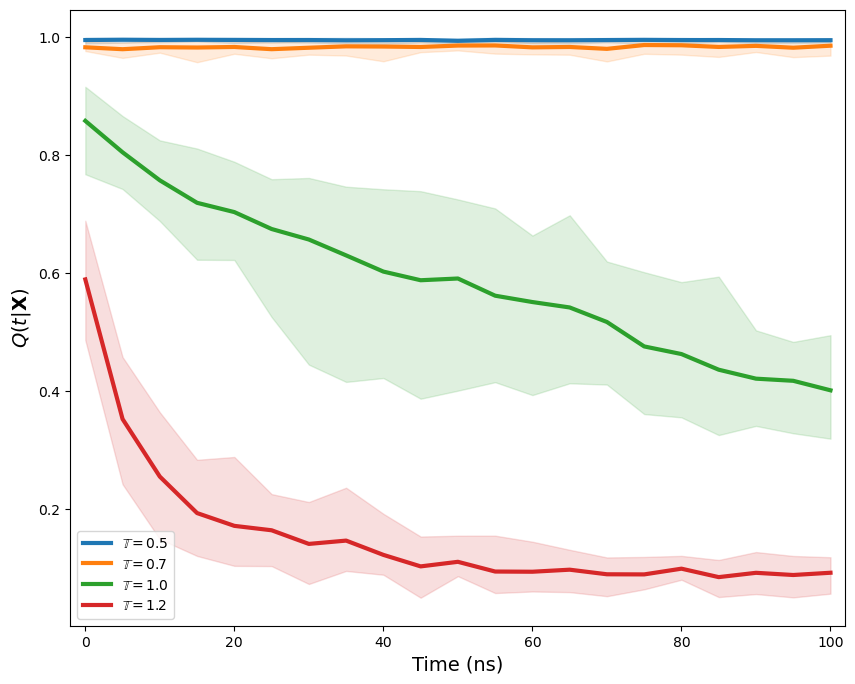

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

mean_temp_traj_list, pct_temp_traj_95_list, pct_temp_traj_05_list = [], [], []
X = np.array(list(range(1000)))[:1001:5]
index = 21
for temperature in temperatures:
    temp_traj = np.array(np.array(data[temperature]))
    mean_temp_traj = temp_traj.mean(0)
    std_temp_traj = temp_traj.std(0)
    pct_temp_traj_95 = np.percentile(temp_traj, 95, axis=0)
    pct_temp_traj_05 = np.percentile(temp_traj, 5, axis=0)
    mean_temp_traj_list.append(mean_temp_traj)
    pct_temp_traj_95_list.append(pct_temp_traj_95)
    pct_temp_traj_05_list.append(pct_temp_traj_05)
        
with plt.style.context('tableau-colorblind10'):
    colormap = mpl.cm.tab10.colors

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(1, 1, 1)
    for i, temperature in enumerate(temperatures):
        temp_traj = np.array(np.array(data[temperature]))
        mean_temp_traj = temp_traj.mean(0)
        std_temp_traj = temp_traj.std(0)
        pct_temp_traj_95 = np.percentile(temp_traj, 95, axis=0)
        pct_temp_traj_05 = np.percentile(temp_traj, 5, axis=0)
        ax.plot(X[:index], mean_temp_traj[:index], color=colormap[i], lw=3, label=r'$\mathbb{T}=$' + '{}'.format(temperature))
        ax.fill_between(X[:index], pct_temp_traj_05[:index], pct_temp_traj_95[:index], alpha=0.15, color=colormap[i])
    
    ax.set_xlim(-2, 102)
    ax.set_xlabel("Time (ns)", fontsize=14)
    ax.set_ylabel(r"$Q(t|\mathbf{X})$", fontsize=14)
    ax.legend()